![](img/logo.png)

# Decision Trees and Random Forests
## Yoav Ram

A decision tree makes decision (or predictions) similar to a [flow chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ValidationCurveDisplay
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.metrics import accuracy_score, r2_score, PredictionErrorDisplay
import sklearn.datasets, sklearn.tree

import seaborn as sns
red, blue, green = sns.color_palette('Set1', 3)
sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

# Data 

We will use the [Pima diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database), originally from the National Institute of Diabetes and Digestive and Kidney Diseases.

The data contains several physiological and demographic features from which we want to predict if the patient has diabetes.

In [2]:
df = pd.read_csv("../data/pima-diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
features = ['Pregnancies', 'Insulin', 'BMI', 'Age','Glucose','BloodPressure','DiabetesPedigreeFunction']
X = df[features].values # Features
y = df['Outcome'].values # Target variable

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) # 70% training and 30% test

Let's have a look at the data.

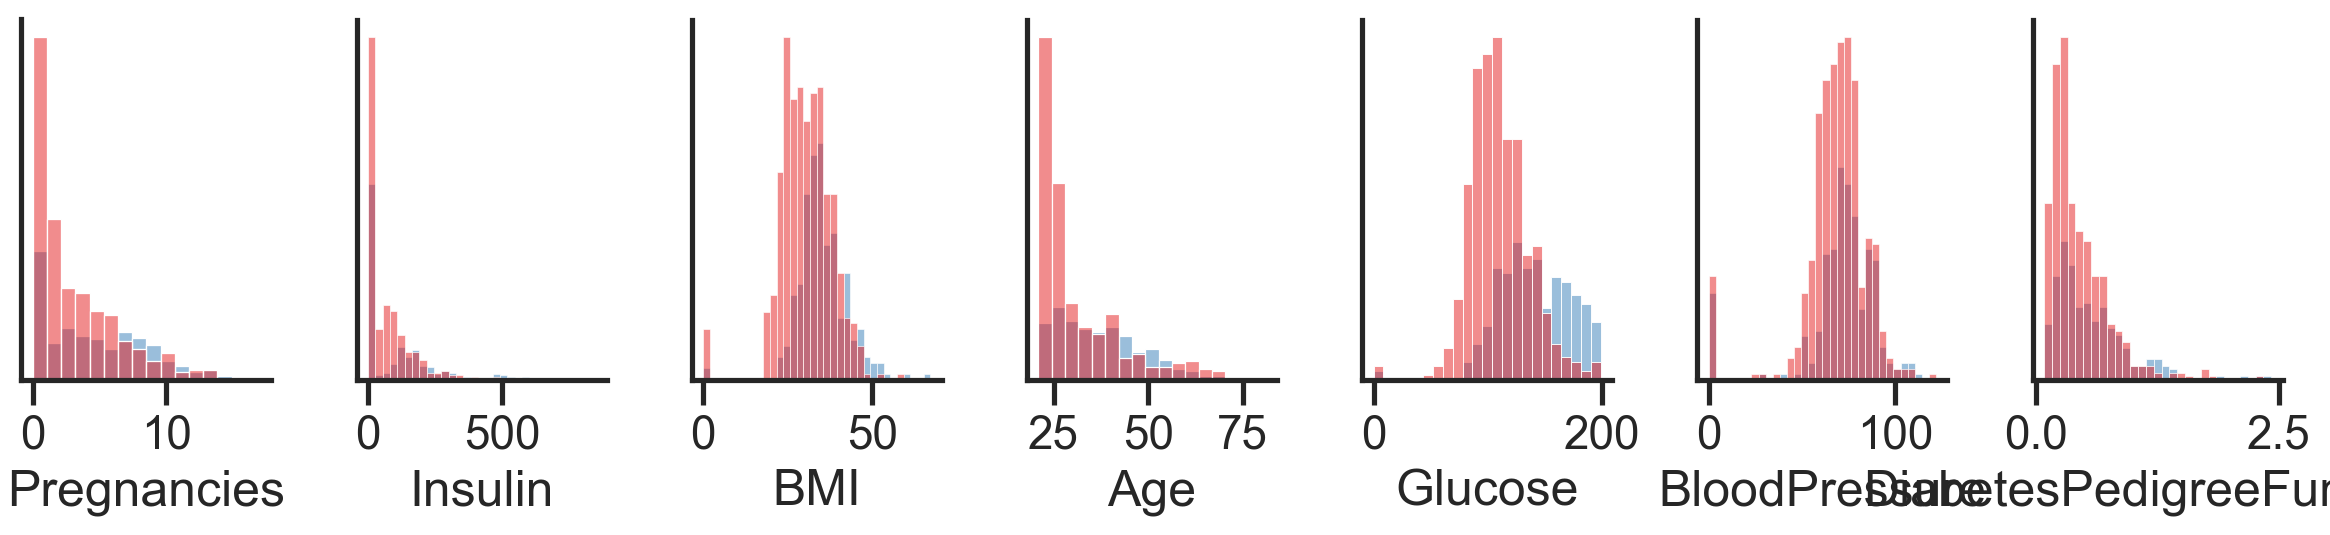

In [5]:
fig, axes = plt.subplots(1, len(features), figsize=(12, 3))
for feature, ax in zip(features, axes):
    sns.histplot(df, x=feature, hue='Outcome', ax=ax, legend=False)
    ax.set(ylabel='', yticks=[])
    sns.despine()
fig.tight_layout()

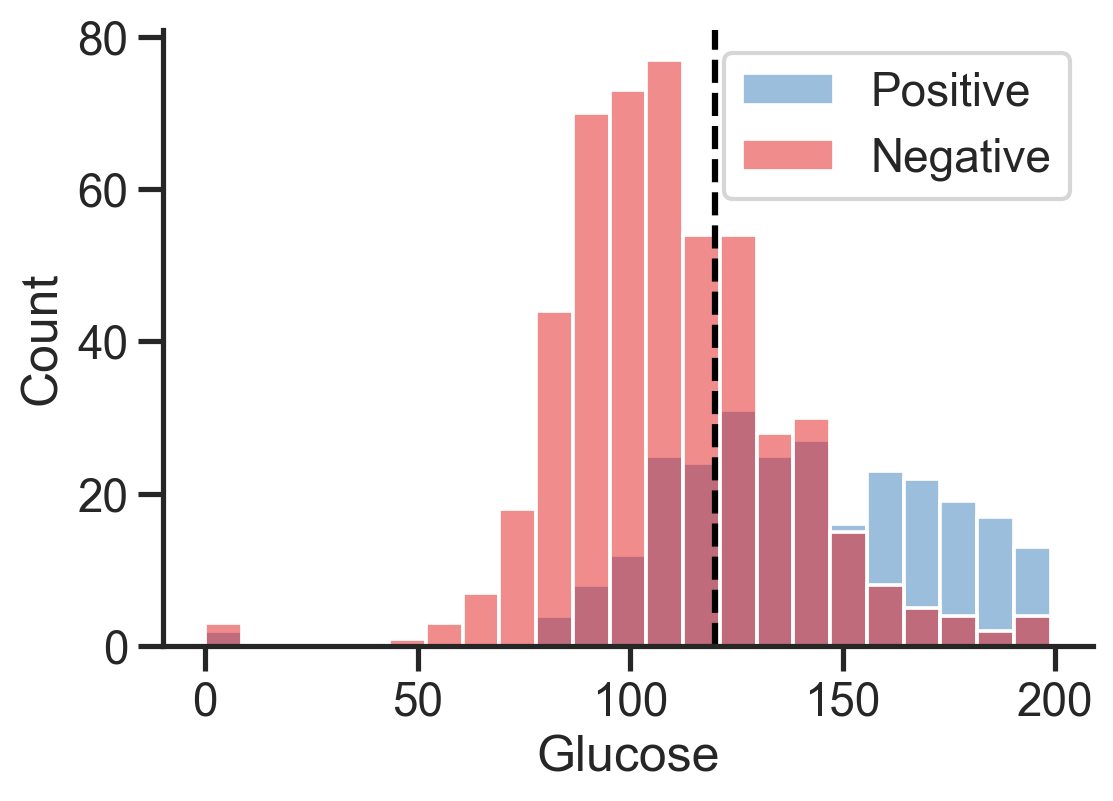

In [6]:
def dist_compare(df, feature, th, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(df, x=feature, hue='Outcome', ax=ax)
    ax.legend(['Positive', 'Negative'])
    ax.axvline(th, color='k', ls='--')
    ax.set_title(title)
    sns.despine()
    
dist_compare(df, 'Glucose', 120)

# Decision tree classifier

How does a decision tree classifier work?

The idea is to construct a series of yes/no questions after which we make a prediction about the class.
Each question focuses on the values of a single feature, and the choice of question can depend on the answers to previous questions.

Let's look at the distributions to try to come up with such questions.

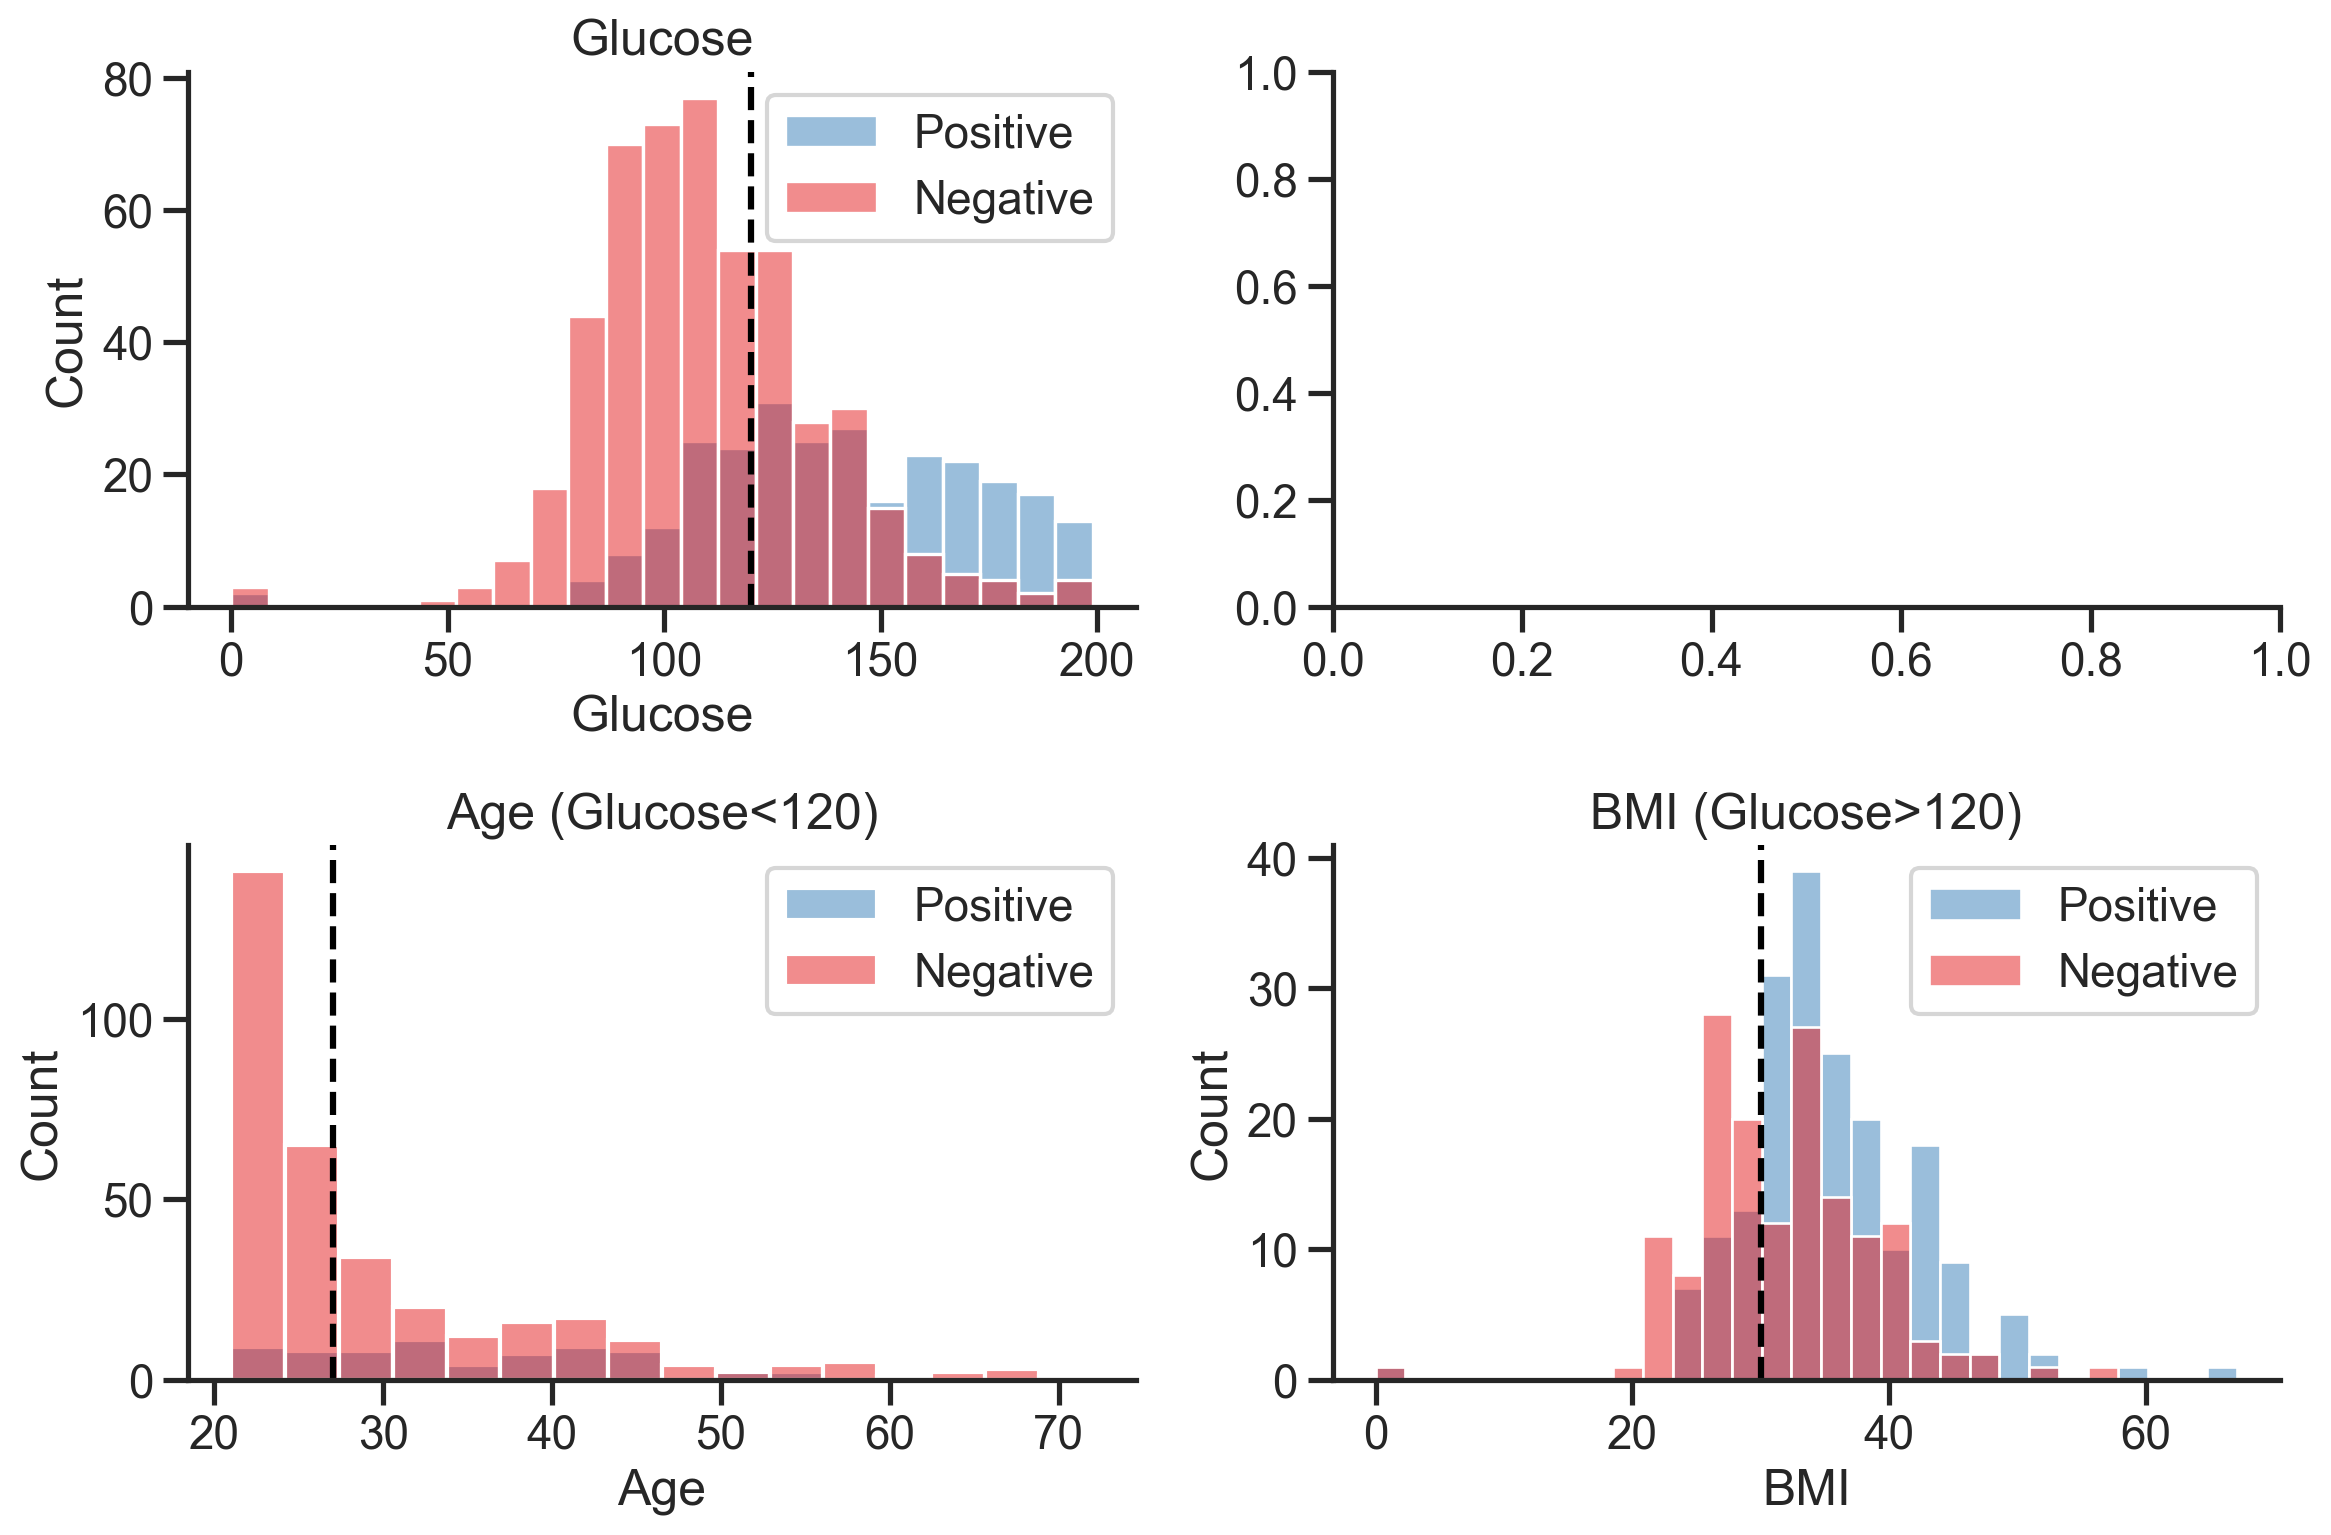

In [7]:
gluc_th = 120
fig, axes = plt.subplots(2, 2, figsize=(12, 8))    
dist_compare(df, 'Glucose', gluc_th, axes[0, 0], 'Glucose')
dist_compare(df[df['Glucose'] < gluc_th], 'Age', 27, axes[1,0], 'Age (Glucose<120)')
dist_compare(df[df['Glucose'] > gluc_th], 'BMI', 30, axes[1,1], 'BMI (Glucose>120)')
fig.tight_layout()

For this dataset, we might ask:
1. If Glucose below 120:
   - If Age below 27: Negative
   - Else: Positive
1. Else: 
   - If BMI below 30: Negative
   - Else: Positive
    
What is the accuracy of such a model?

In [31]:
def predict(df):
    return ((df['Glucose'] < 120) & (df['Age'] > 27)) | ((df['Glucose'] >= 120) & (df['BMI'] > 30))

yhat = predict(df)
print("Accuracy:", (yhat == df['Outcome']).mean())

Accuracy: 0.6458333333333334


Not very impressive, as the number of negative outcomes (zero) is about 0.65, so a model that always says "negative" will have the same accuracy.

In [32]:
print((df['Outcome'] == 0).mean())

0.6510416666666666


To get a better results, we need to come up with a series of such questions in a way that we minimize the [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) of each additional "partition" made by the yes-no questions.

Gini impurity estimates the probability to make a classificaion error. That is, if the answer to some question determines the classification, what does the question need to be so that as many "positive" will be on one side, and as many "negatives" will be on the other side?

Let's use Scikit-learn to construct a decision tree.

In [33]:
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.70995670995671


What does this model actually do? Let's [visualize it](https://mljar.com/blog/visualize-decision-tree/).

In [34]:
print(sklearn.tree.export_text(classifier, feature_names=features, max_depth=3))

|--- Glucose <= 143.50
|   |--- Age <= 30.50
|   |   |--- BMI <= 31.40
|   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- Pregnancies >  7.50
|   |   |   |   |--- class: 1
|   |   |--- BMI >  31.40
|   |   |   |--- BloodPressure <= 37.00
|   |   |   |   |--- class: 1
|   |   |   |--- BloodPressure >  37.00
|   |   |   |   |--- truncated branch of depth 11
|   |--- Age >  30.50
|   |   |--- Glucose <= 99.50
|   |   |   |--- BMI <= 34.65
|   |   |   |   |--- class: 0
|   |   |   |--- BMI >  34.65
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- Glucose >  99.50
|   |   |   |--- BMI <= 26.90
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- BMI >  26.90
|   |   |   |   |--- truncated branch of depth 10
|--- Glucose >  143.50
|   |--- Glucose <= 159.50
|   |   |--- DiabetesPedigreeFunction <= 0.31
|   |   |   |--- BloodPressure <= 55.00
|   |   |   |   |--- class: 1
|   |   |   |--- BloodPressure >  55.00
|   

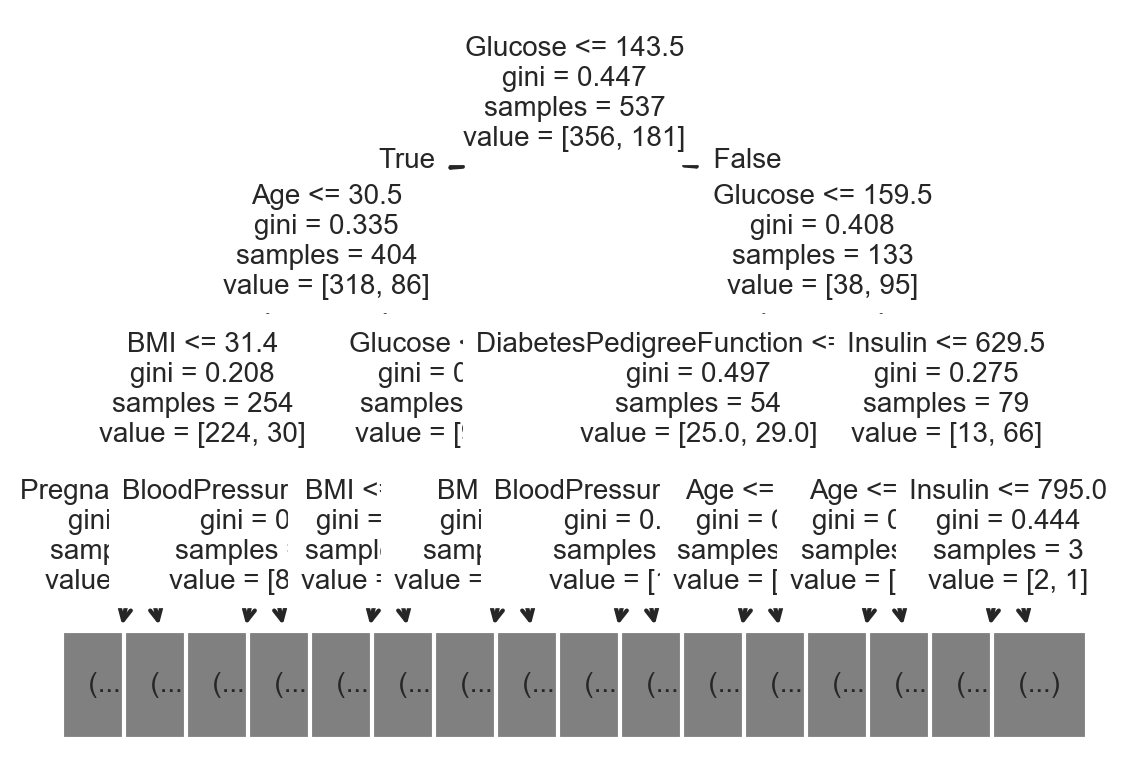

In [35]:
sklearn.tree.plot_tree(classifier, feature_names=features, max_depth=3, fontsize=10);

# Tree ensembles

## Bagging
As we saw, the decision tree only gave us accuracy of about 65%. How can we improve upon it?

A common way to improve it is to use a simple ensemble algorithm: [_Bagging_](https://en.wikipedia.org/wiki/Bootstrap_aggregating). 

In ensemble algorithms, a set of models is trained, and prediction is made using some decision rule on the set of predictions.
See more in:
> Dietterich, Thomas G. 2000. [_Ensemble Methods in Machine Learning_](https://doi.org/10.1007/3-540-45014-9_1). In Multiple Classifier Systems, 1857:1–15. Lecture Notes in Computer Science. Springer Berlin Heidelberg.

Bagging means that we train the same model, but each time with a different resample of the data.

Bagging can be used with any model using Scikit-learn implementation (`BaggingClassifier`), but we will first implement it ourselves.
Let's see how that works with just 3 trees - first by fitting each tree to a resample of the dataset.

In [36]:
trees = [DecisionTreeClassifier() for i in range(3)]
for tr in trees: # this can be parallelized
    n = X_train.shape[0]
    idx = np.random.choice(n, n, replace=True)
    X_, y_ = X_train[idx], y_train[idx]        
    tr.fit(X_, y_)

In [37]:
print("Accuracy: ")
for tr in trees:
    print(tr.score(X_test, y_test))

Accuracy: 
0.696969696969697
0.670995670995671
0.6363636363636364


Here's what each tree says for each sample in the test set (printing just the first 30 samples):

In [38]:
yhat = np.array([tr.predict(X_test) for tr in trees])
print(yhat[:, :30])

[[0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1]
 [1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1]]


We can then predict using a majority rule:

In [39]:
yhat = yhat.sum(axis=0) >= 2
yhat = yhat.astype(int)
print(yhat[:30])

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1]


Amazingly, the accuracy of the ensemble is greater then the accuracy of any one tree:

In [40]:
print("Accuracy: ", (yhat == y_test).mean())

Accuracy:  0.7142857142857143


## Random forest

A **random forest** is an ensemble of decision trees in which the trees are randomly produced by both bagging (sampling rows), and random selection of features (randomizing columns).

We will use Scikit-learn's random forest classifier.

In [41]:
classifier = RandomForestClassifier(n_estimators=10)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7489177489177489


How many trees should we use? The more the better? Are there diminishing returns? 
Each tree adds computational cost, both to the training and to the prediction, although much of the algorithm can be parallelised as different trees are independent.

We can create a **validation curve** which uses [cross-validation](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg) to train several models (here, random forest models), each with a different meta-parameter value (here, `n_estimators` that determines the number of trees in the forest), and displays the result.

As we can see, there seems to be diminishing returns, and using more than 20 trees doesn't seem to add much.

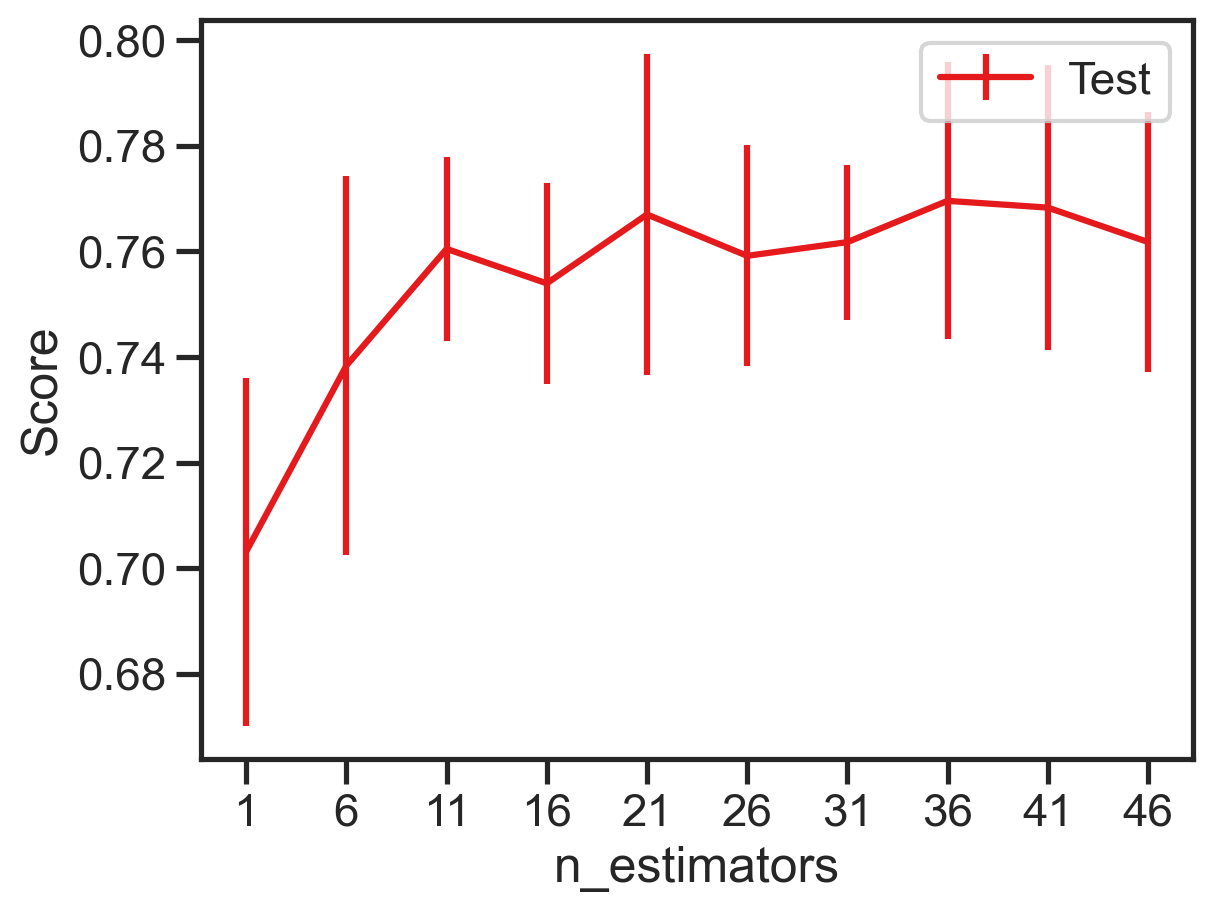

In [42]:
disp = ValidationCurveDisplay.from_estimator(
    classifier, X, y, score_type='test',
    param_name='n_estimators', param_range=np.arange(1, 51, 5), 
    std_display_style="errorbar"
)
plt.xticks(disp.param_range);

# Decision tree regressor

Decision trees can also be used for regression. In this case, the decision on each question is the mean of all the train examples that passed that question, and the algorithm that builds the tree attempts to minimize the root mean squared error, similar to many regression models.


We'll work with the diabetes dataset:
> Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

In [19]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
feature_names = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
n_features = len(feature_names)

df = pd.DataFrame(data=X, columns=feature_names)
df['target'] = y
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

In [21]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
print("R2 = {:.3f}".format(regressor.score(X_test, y_test)))

R2 = -0.128


The score is the coefficient of determination $R^2$, which measures the fraction of variance explained by the model.

We can use a prediction error plot to see how the residuals ($y-\hat{y}$) are distributed.

We will plot one for the train set--which is not interesting, because the tree remembers the train values, but it will serve later for comparison--and one for the test set. 

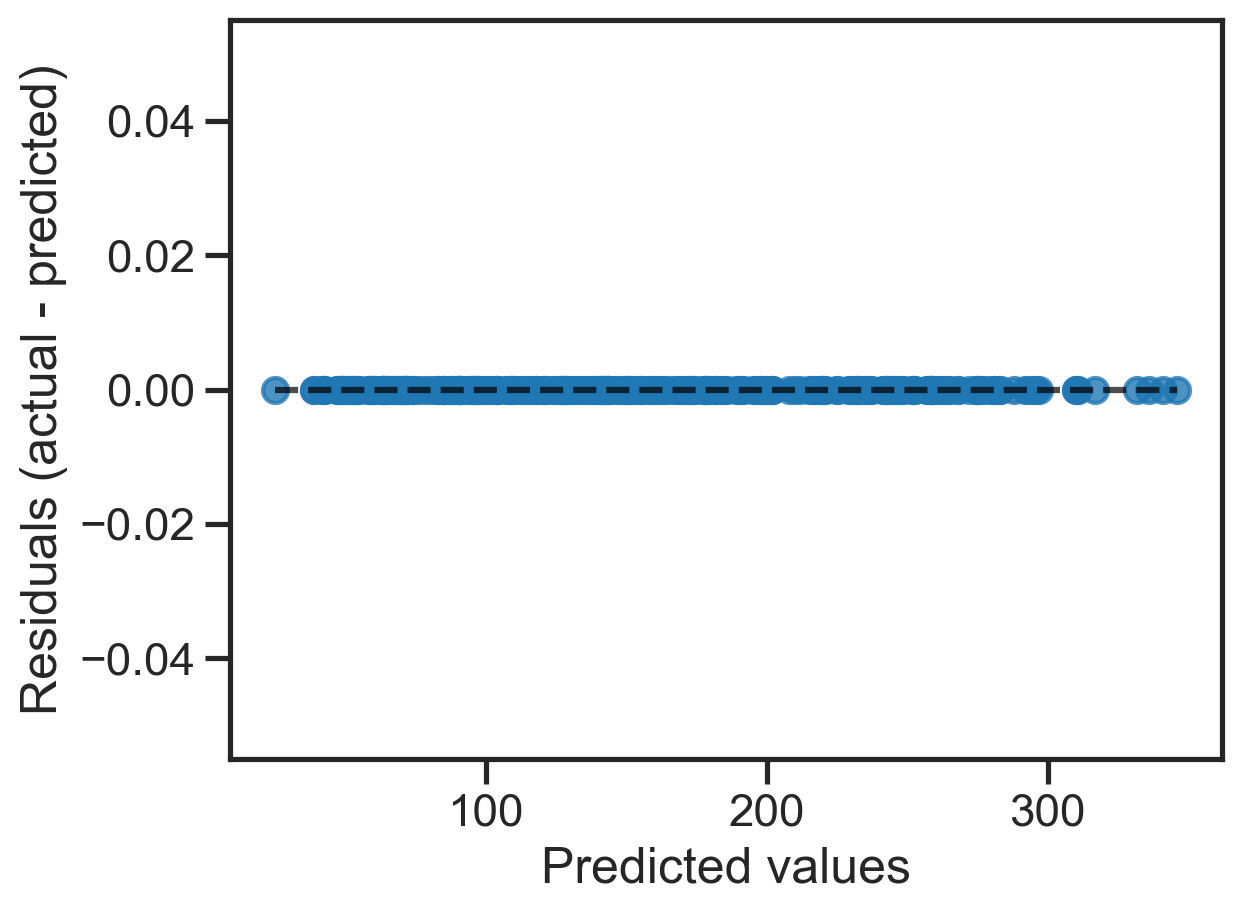

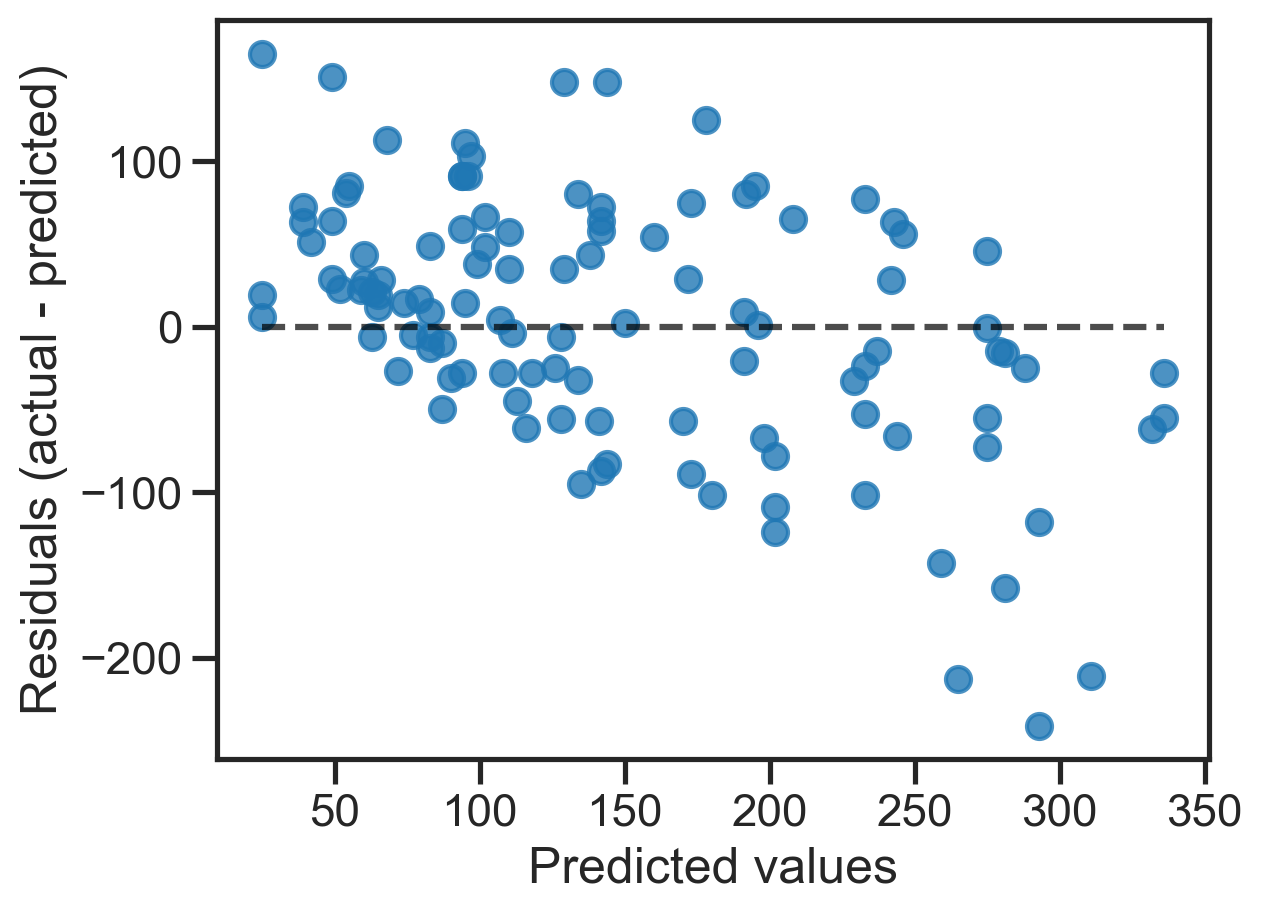

In [30]:
PredictionErrorDisplay.from_estimator(regressor, X=X_train, y=y_train, kind="residual_vs_predicted");
PredictionErrorDisplay.from_estimator(regressor, X=X_test, y=y_test, kind="residual_vs_predicted");

You can see that low predictions have positive residuals--under-estimations--and vice-versa, high predictions have negative residuals--over-estimations. So we are over-shooting.

Perhaps a random forest will fare better?

# Random forest regressor

We can, of course, use a random forest for this task. 
Here, it takes the *average prediction* of the ensemble rather than the majority--this should fix our problem of over-shooting.

In [22]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
print("R2 = {:.3f}".format(regressor.score(X_test, y_test)))

R2 = 0.499


The $R^2$ is higher--and importantly, it is positive!

Let's look at the residuals. This time it makes sense to look at the train, not just the test, examples, because we would like to see how much the forest is better on one compared to the other. Each tree "remembers" all the train values, but the ensemble aggregates these "memories".

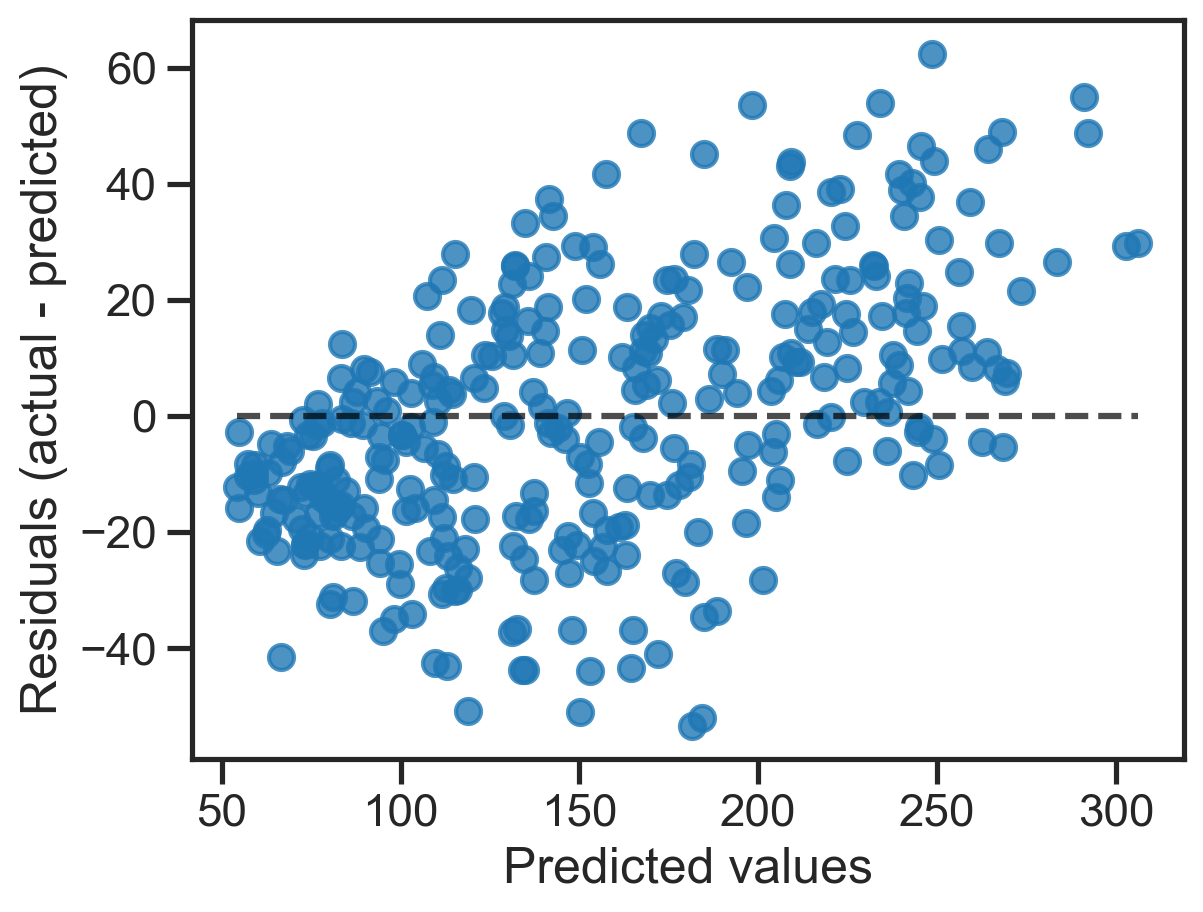

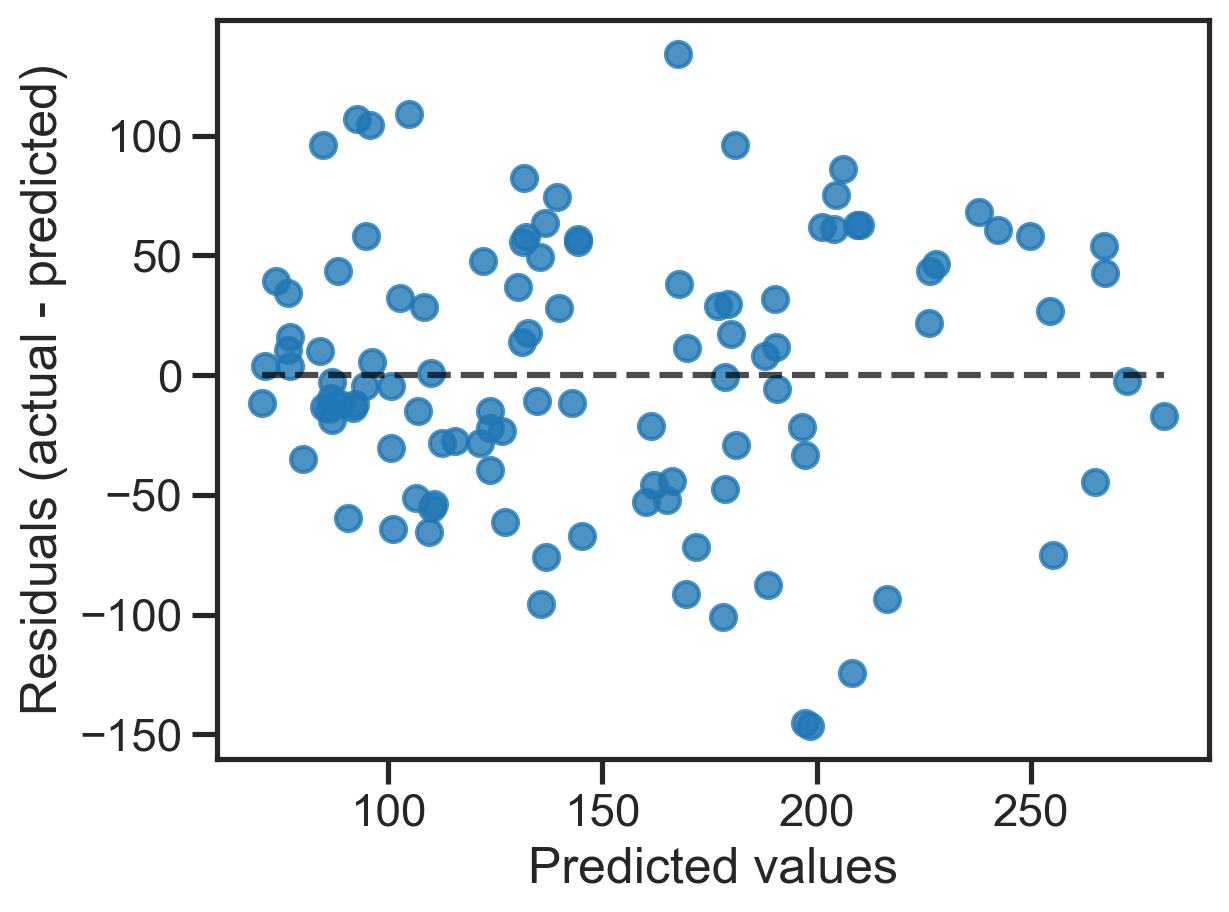

In [32]:
PredictionErrorDisplay.from_estimator(regressor, X=X_train, y=y_train, kind="residual_vs_predicted");
PredictionErrorDisplay.from_estimator(regressor, X=X_test, y=y_test, kind="residual_vs_predicted");

This is pretty good. Although we do see a bias in the training set value, this bias does not appear in the test values.

# Multi-output regression

In some cases we with to predict more than a single target, and we think that these targets are correlated in some way, such that it makes sense to predict all of the targets using a single model. 

Random forests can be very efficient in such problems.
The algorithm for multi-target regression (and classification) needs to be adjusted to store multiple output values in each leaf rather than a single value, and to use splitting criteria that average the reduction across all outputs. This is already implemented in scikit-learn's decision trees and random forests.

We will use the [Olivetti faces dataset](https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset).
Here, `X` are 64x64 images, and `ids` are person identifiers.

In [23]:
X, ids = sklearn.datasets.fetch_olivetti_faces(return_X_y=True)

In [24]:
def plot_face(x, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(x.reshape(64, 64), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

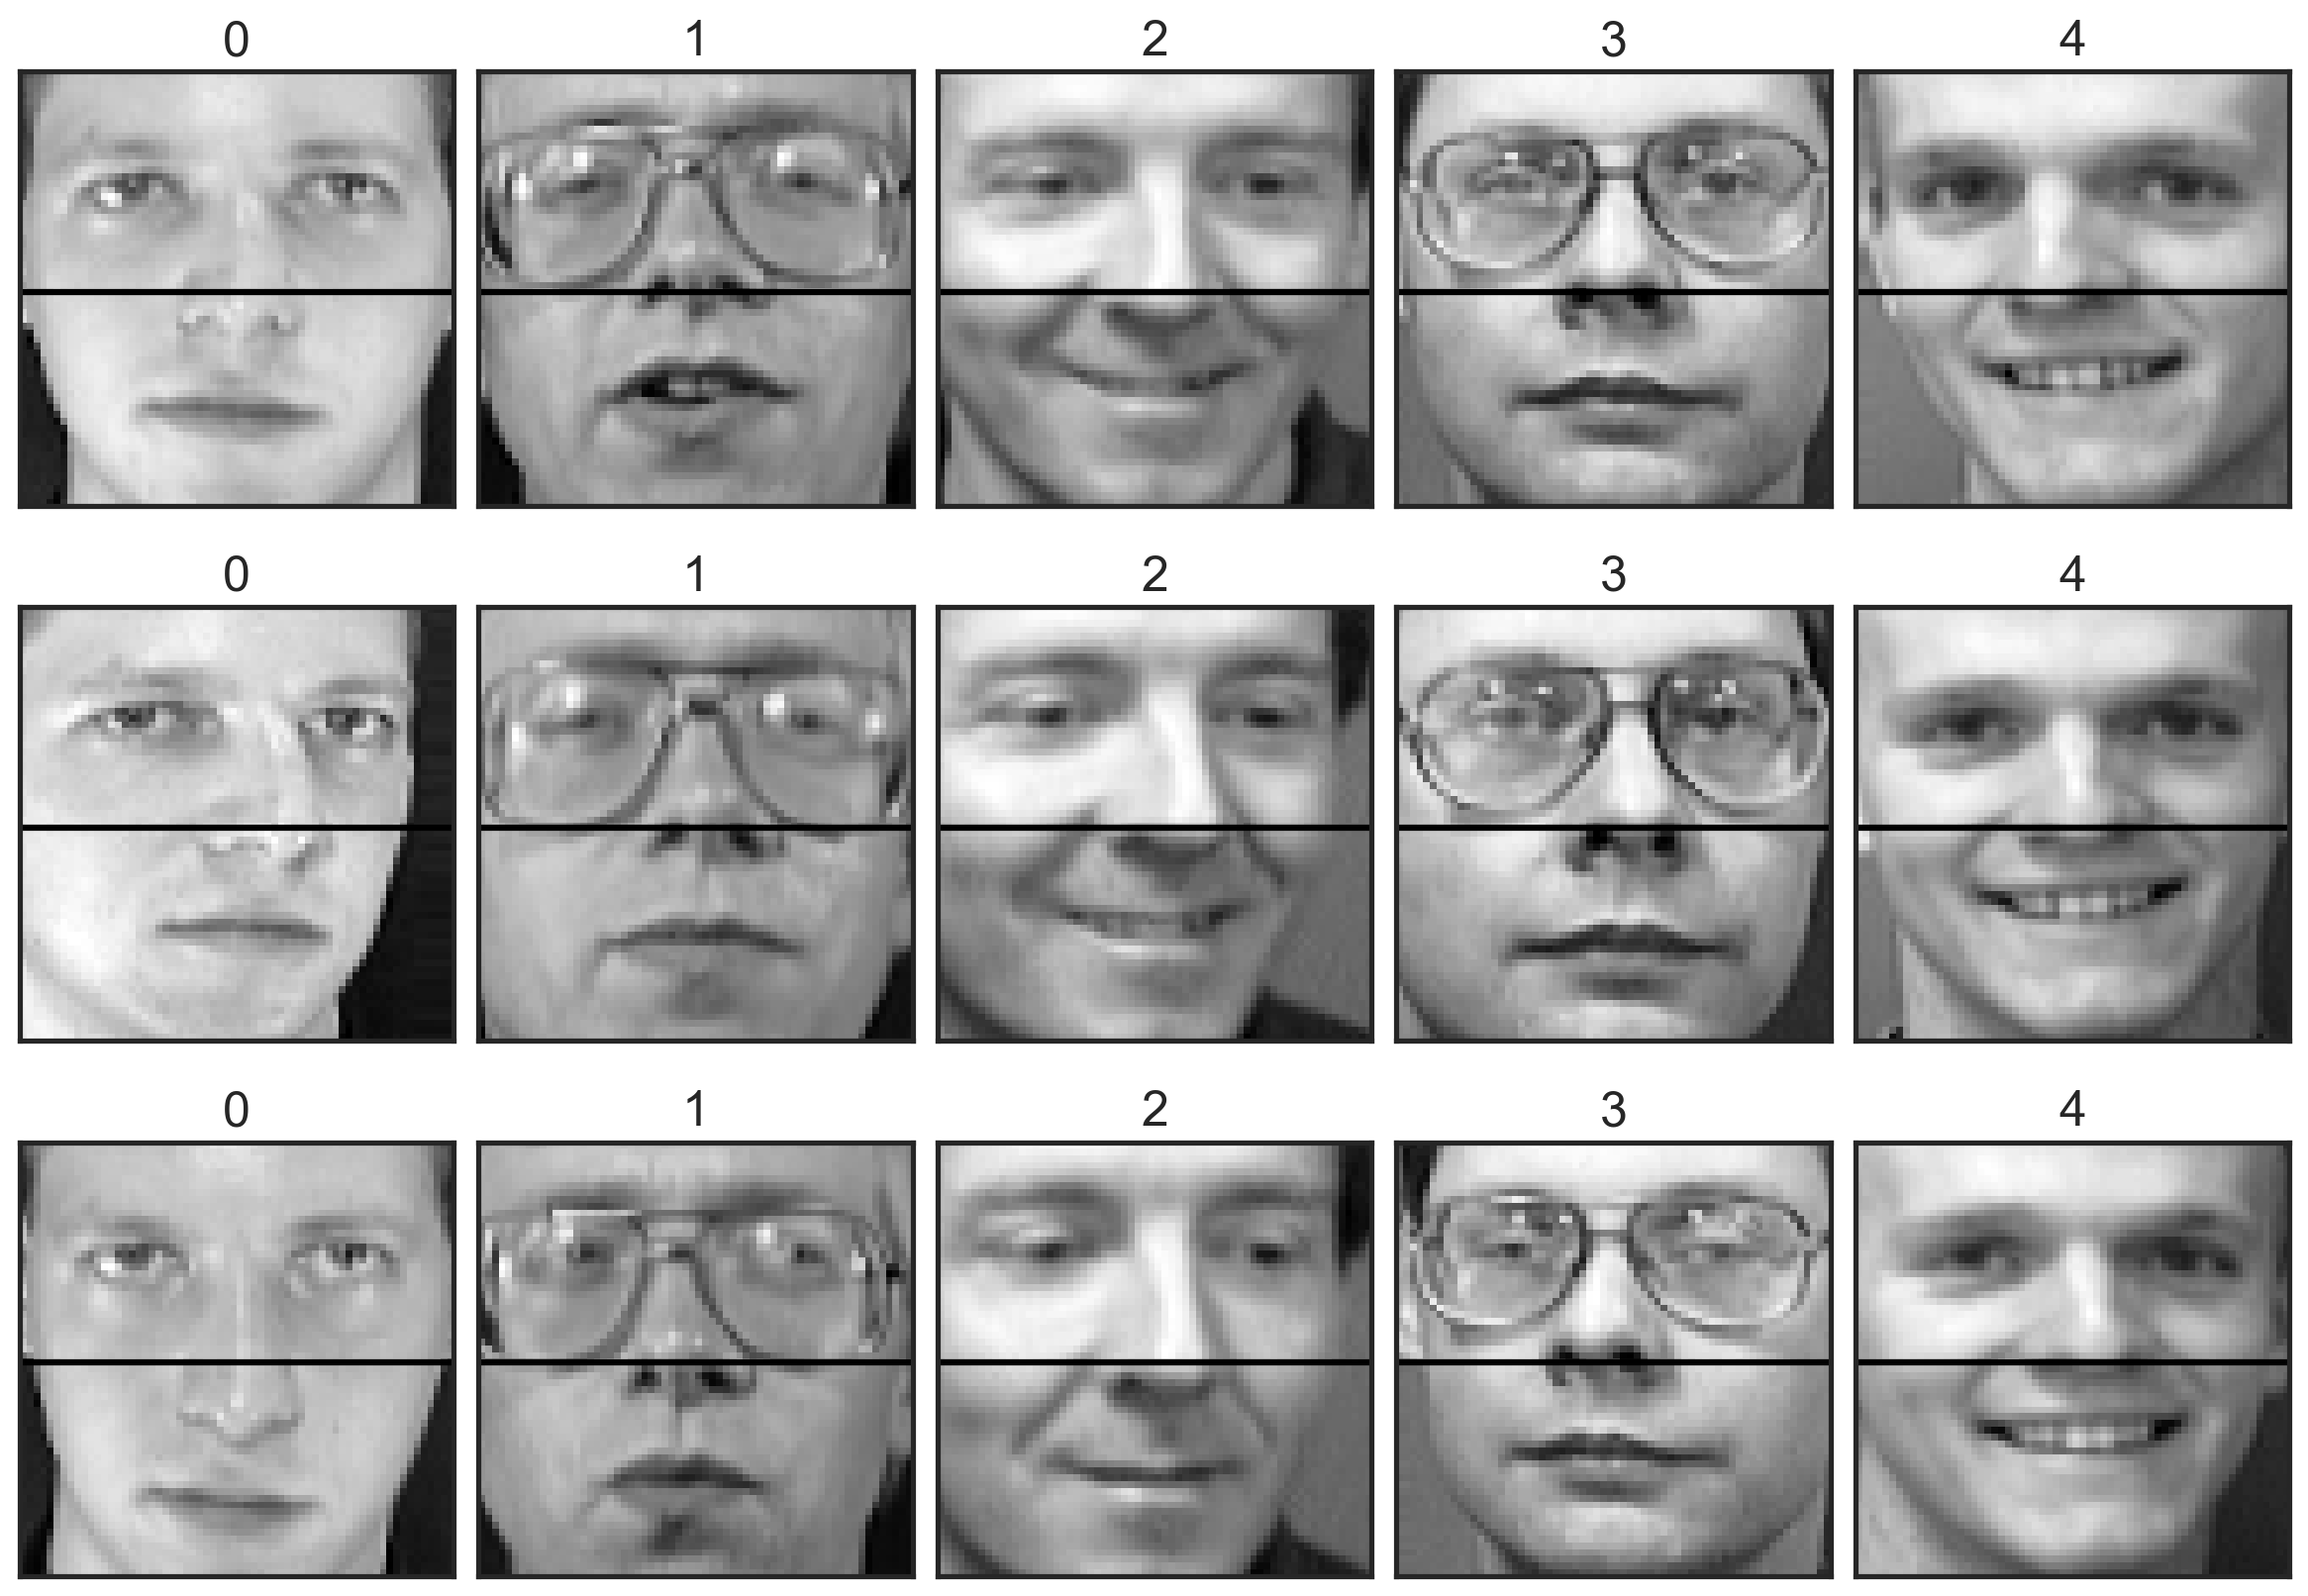

In [35]:
fig, axes = plt.subplots(3, 5, figsize=(12, 12))
for j in range(3):
    for i in range(5):
        ax = axes[j,i]
        img = X[i*10+j]
        plot_face(img, ax=ax)
        ax.set_title(i)
        ax.axhline(32, color='k')
fig.tight_layout(h_pad=-10, w_pad=0.5)

We will try to predict the bottom half of the image from the top half.
We will train on ids 0-29 and test on ids 30-39.

So we create the relevant train and test sets.

In [36]:
n_pixels = X.shape[1]

X_train = X[ids<30, : (n_pixels + 1) // 2]
Y_train = X[ids<30, n_pixels // 2 :]

X_test = X[ids>=30, : (n_pixels + 1) // 2]
Y_test = X[ids>=30, n_pixels // 2 :]

Now we train the random forest regressor. You can increase the number of estimators, but it will take longer to train.

In [37]:
regressor = RandomForestRegressor(n_estimators=10)
regressor.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=10)

Let's see how it performs on some traininig images.

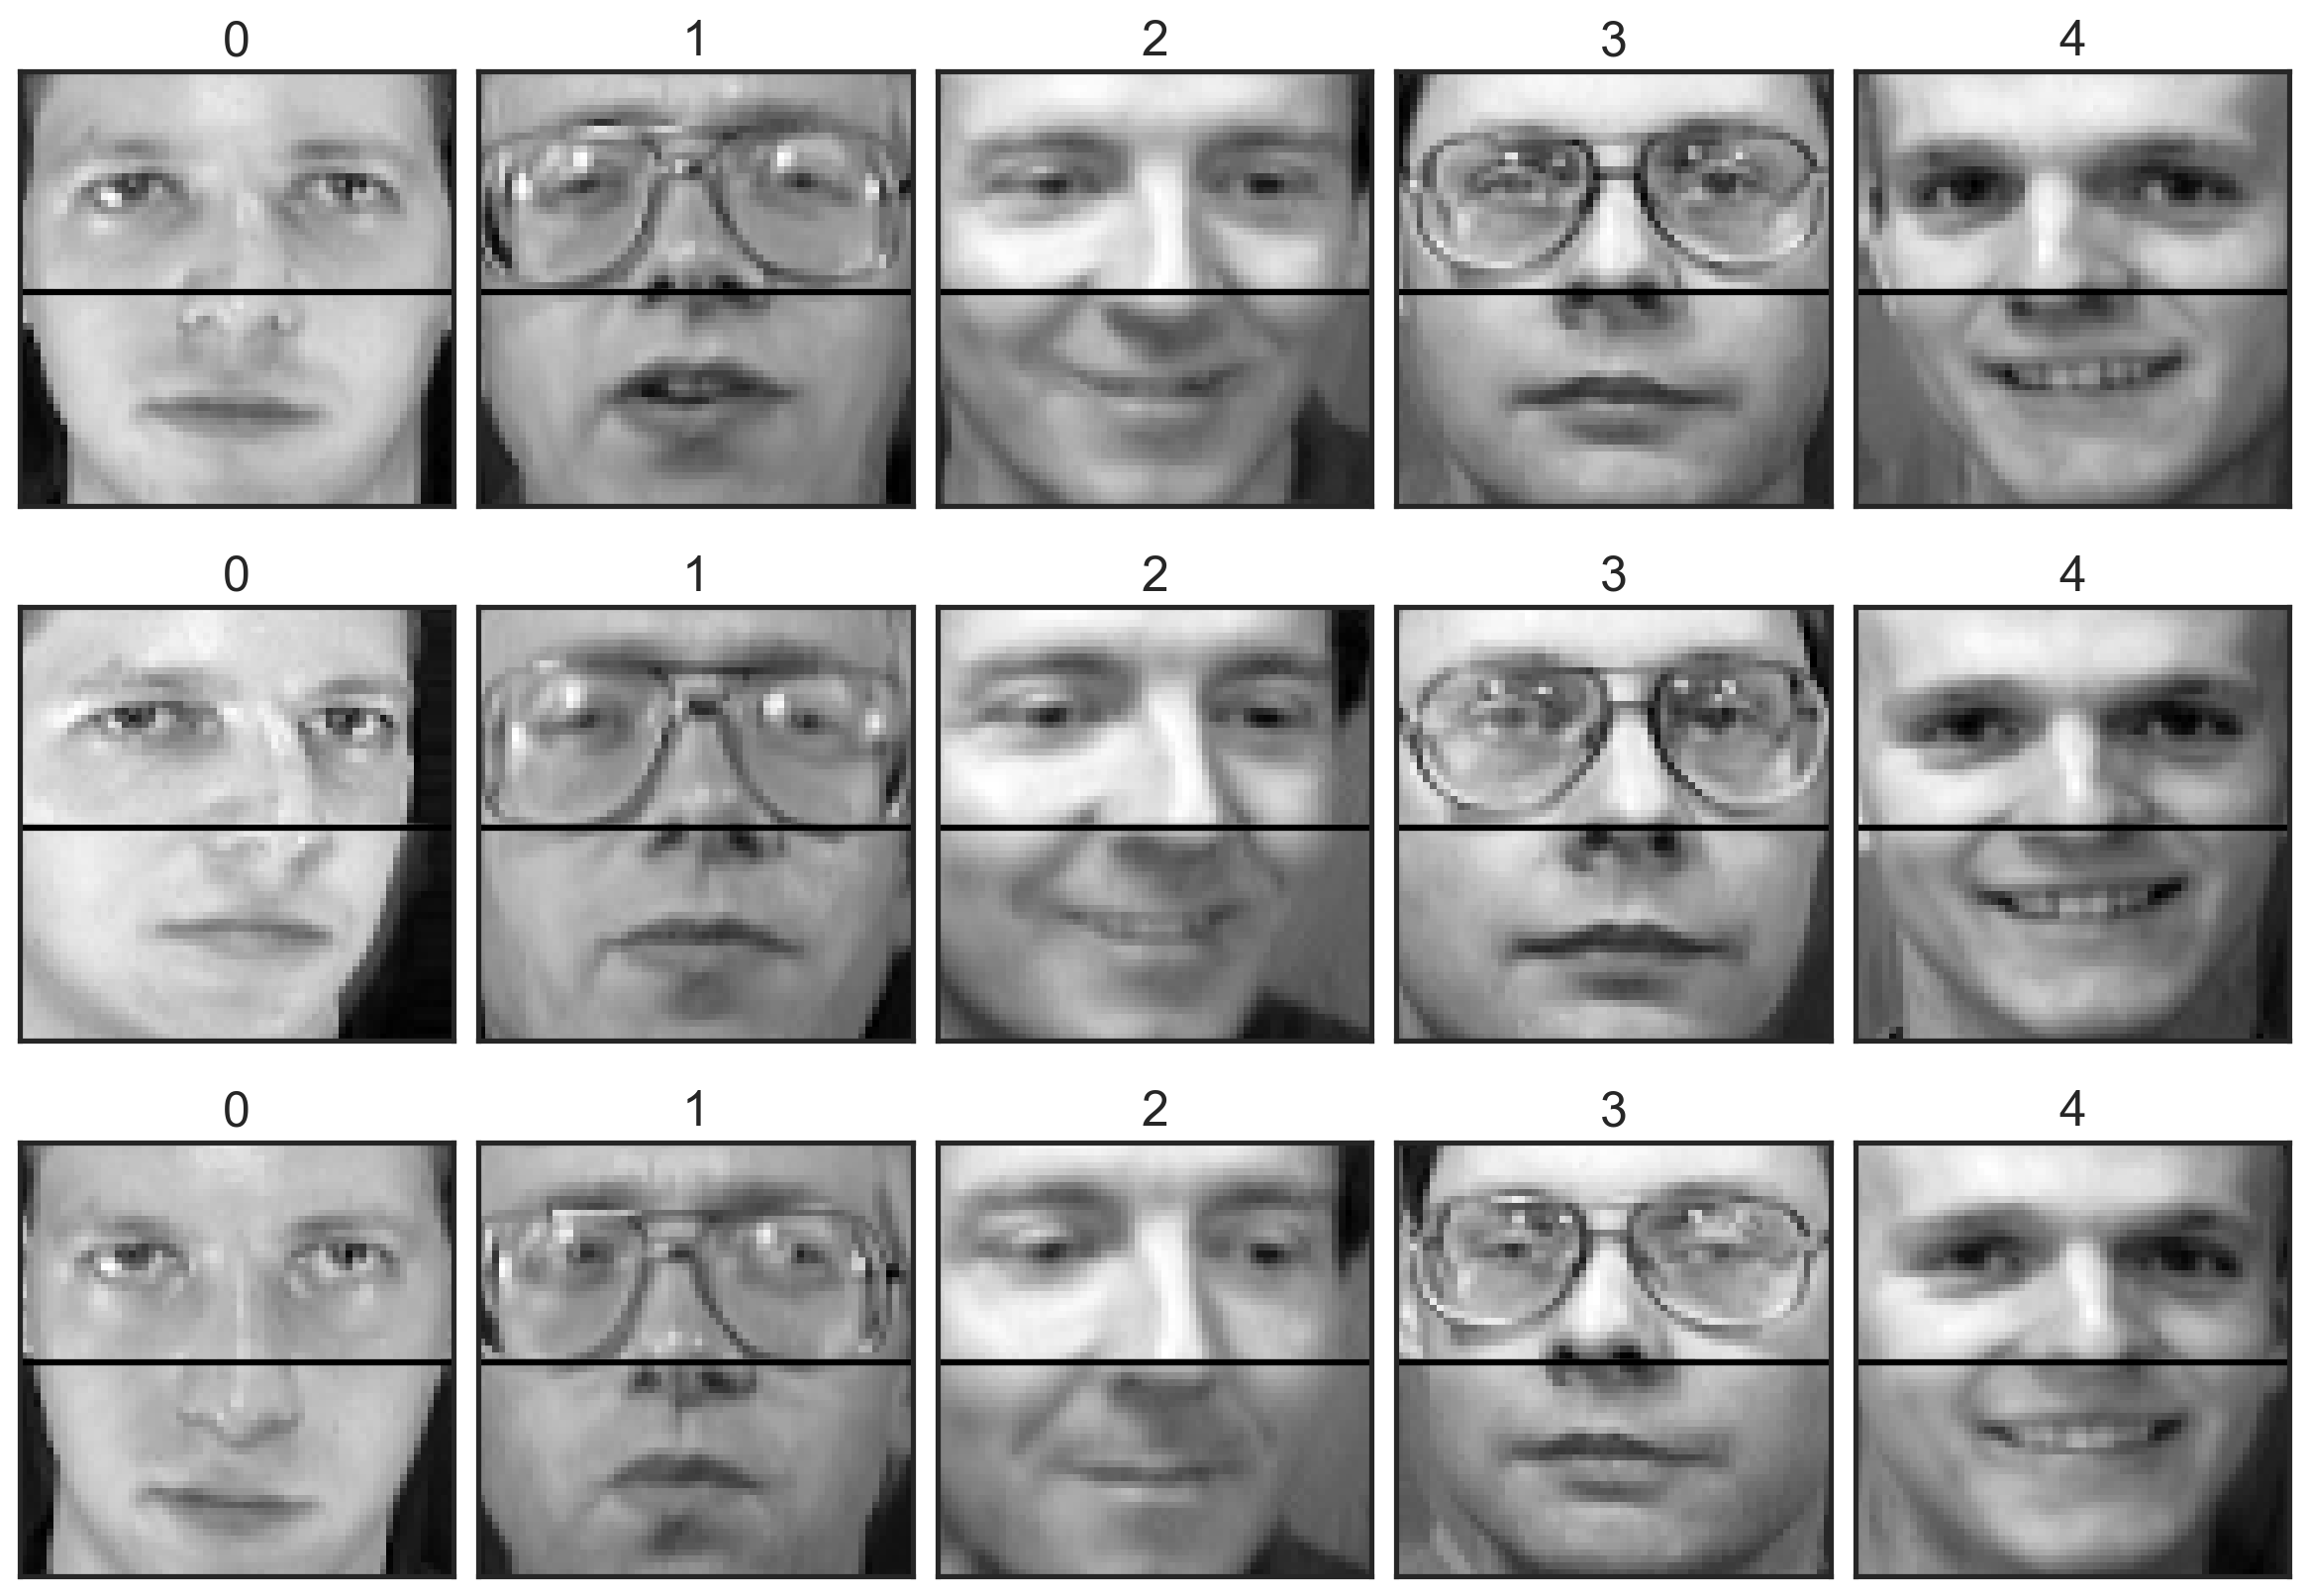

In [38]:
fig, axes = plt.subplots(3, 5, figsize=(12, 12))
for j in range(3):
    for i in range(5):
        ax = axes[j,i]
        x = np.atleast_2d(X_train[i*10+j])
        y_hat = regressor.predict(x)
        img_hat = np.hstack((x, y_hat))
        plot_face(img_hat, ax=ax)
        ax.set_title(i)
        ax.axhline(32, color='k')
fig.tight_layout(h_pad=-10, w_pad=0.5)

That's pretty good!

Now let's try some test images.

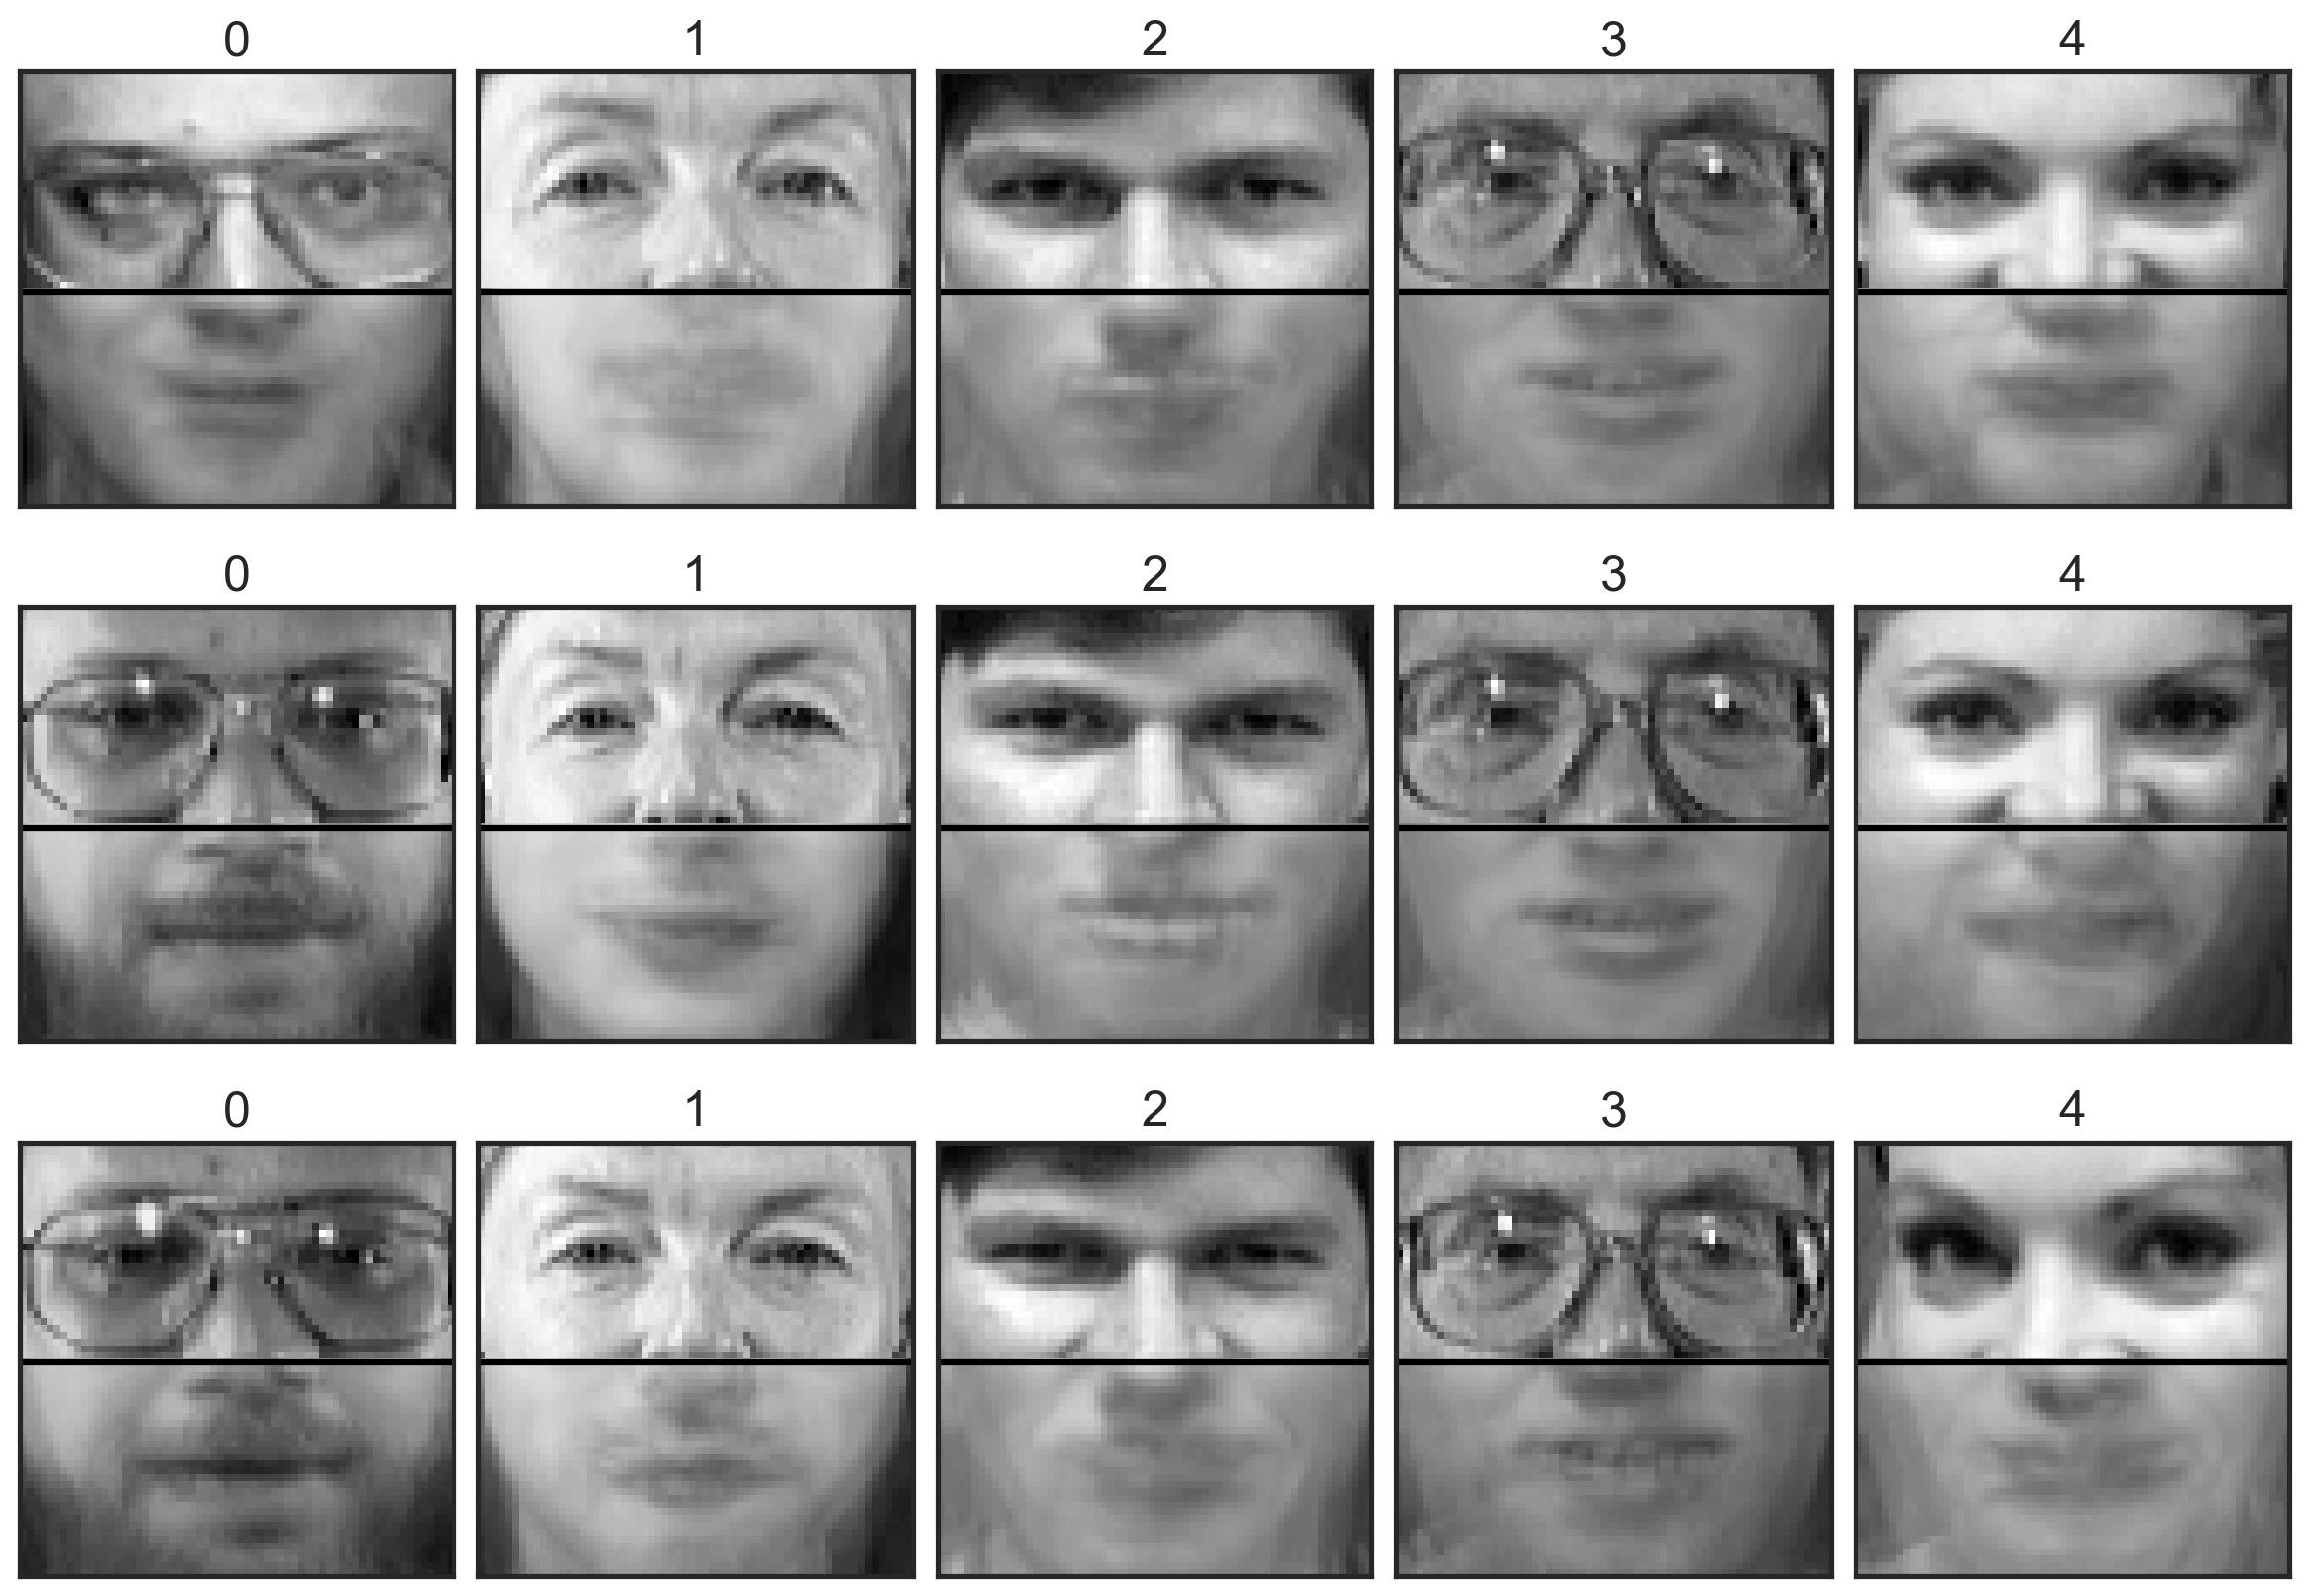

In [39]:
fig, axes = plt.subplots(3, 5, figsize=(12, 12))
for j in range(3):
    for i in range(5):
        ax = axes[j,i]
        x = np.atleast_2d(X_test[i*10+j])
        y_hat = regressor.predict(x)
        img_hat = np.hstack((x, y_hat))
        plot_face(img_hat, ax=ax)
        ax.set_title(i)
        ax.axhline(32, color='k')
fig.tight_layout(h_pad=-10, w_pad=0.5)

This is not bad for a first attempt and a non-specialized, non-deep model.

We could try to improve the results using more trees in the forest, or by using other tree ensemble methods ([Extremely Randomized Trees](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees), [Gradient Boosting Trees](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)). 

# Decision trees from scratch

In the next sections we implement everything "by hand" using NumPy to provide a deeper look at how the algorithms work.

## Decision tree classifier

Influenced by [blog post in Curiousily](https://www.curiousily.com/posts/build-a-decision-tree-from-scratch-in-python/).
For simplicity, we focus on binomial classification, but everything easily extends to multinomial classification.

The decision tree is a binary tree.
Each branching node $n$ specifies a specific feature $j_n$ and a split value $x_n$.
Each leaf $l$ specifies a classification prediction $p_l$, i.e. the probability that the correct class if "1".

When the decision tree is used for prediciton, we start we a set of feature values $X=(x_1, \ldots, x_M)$ at the root of the tree, so we start at node $n=0$.
We then iteratively traverse the tree until we reach a leaf by choosing the left branch if the value of this node's feature is less than this node's split value:
$$
x_{j_n} < x_n,
$$
and otherwise we choose the right branch.
When we find a leaf $l$, we use that leaf's classification prediction $p_l$.

How is the tree constructed?
We present a simple algorithm, but more sophisticated ones exist.

We start with the root branch, $n=0$ with all our examples $i=1,2,\ldots,N$.

We want to choose a feautre $j_n$ and split value $x_n$ that, if we branch with this feaure and split value, we will minimize some loss function. This loss function is computed on both branches, and we use the  weighted average of the losses on both branches. We will discuss the specific loss function later.

To do this, we iterate over all $M$ features, and for every feature, on all $Nn$ samples, and for each sample $i$ of each feature $j$, we branch the set of examples, compute the loss for each branch, and compute the average loss.
We choose the feature and split value that gave the minimal loss, and set them as the feautre $j_n$ and spit value $x_n$ of this node.

Then we branch the examples to those below and those above the split value, and we create two new nodes $n_L$ and $n_R$, the left node $n_L$ for the "below" values, and the right node $n_R$ for the "above" value.
We then repeat the whole process for both nodes.
So this is a greedy recursive algorithm (and we can probably make it more efficient or at least parallelize it).

Like any recursion we must have a stop condition. When do we stop? When the number of examples in a node raches some minimial value `min_leaf`, we call that node a leaf.

Thats it. We implement this in the `Node` class.

In [25]:
class Node:
    def __init__(self, x, y, loss_func, min_leaf=5):
        ''' x: data, rows for samples, columns for features
            y: labels, rows for samples
            min_leaf: number of samples in node to make it a leaf
        '''
        # it is a leaf unless we decide otherwise
        self.is_leaf = True
        # set the value to average y / fraction of 1s in y, in case this is a leaf
        self.value = y.mean()
        
        # look for the feature (column or j) and split value that give the lowest loss
        best_j, best_split, best_loss = 0, np.inf, np.inf
        # iterate over columns looking for a good feature
        for j in range(x.shape[1]):
            xj = x[:, j]
            # iterate over rows looking for a good split - this can be parallelized
            for xij in xj:
                left_idx = xj <= xij
                right_idx = ~left_idx # rhs = not lhs
                # if either side is too small, go to next split
                if left_idx.sum() < min_leaf:
                    continue
                if right_idx.sum() < min_leaf:
                    continue
                # compute score
                loss_ij = loss_func(y[left_idx], y[right_idx])
                # if this is the lowest loss so far, save it
                if loss_ij < best_loss:
                    best_loss = loss_ij
                    best_split = xij
                    best_j = j
        # no loss found, its a leaf, finish 
        if np.isinf(best_loss):
            return
        # loss was found, save to attributes
        self.is_leaf = False
        self.feature = best_j
        self.split = best_split
        
        # prepare to branch the tree
        xj = x[:, best_j]
        lhs = np.nonzero(xj <= best_split)[0]
        rhs = np.nonzero(xj > best_split)[0]
        # branch the tree to left and right
        self.left = Node(x[lhs, :], y[lhs], loss_func, min_leaf)
        self.right = Node(x[rhs, :], y[rhs], loss_func, min_leaf)
    
    
    def predict(self, x):
        if self.is_leaf:
            return self.value
        
        if x[self.feature] <= self.split:
            return self.left.predict(x)
        else:
            return self.right.predict(x)

The loss function we will use is called [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity). 

For simiplicity, let's assume binomial classifcation, i.e. only two possible class (this can easily be extended to more then two classes).
Gini impurity attempts to estimate the probability to make a classificaion error.
We assume set of $n$ elements, of which $p_0$ are of class "0" (e.g. fail) and $p_1$ are of class "1" (e.g. success).
Without any other information, we have a $p_0$ chance to say that a random element is "0" and $p_1$ chance to say it is "1". 
So the Gini impurity is

$$
\text{gini} = P(\text{draw}\; 0, \text{say}\; 1) + P(\text{draw}\; 1, \text{say}\; 0) = \\
p_0 p_1 + p_1 p_0 = p_0 (1-p_0) + p_1 (1-p_1) = p_0 + p_1 - p_0^2 - p_1^2 = \\
1 - (p_0^2 +p_1^2)
$$

In [26]:
def gini(y_left, y_right):
    p1_left = y_left.mean() # frequency of 1s
    p0_left = 1 - p1_left # frequency of 0s
    gini_left = (1 - (p0_left * p0_left + p1_left * p1_left))
    p1_right = y_right.mean()
    p0_right = 1 - p1_right
    gini_right = (1 - (p0_right * p0_right + p1_right * p1_right))
    return gini_left * len(y_left) + gini_right * len(y_right)

We now wrap the whole thing in a Scikit-learn-like classifier object that has a constructor method `__init__`, a `fit` method, and a `predict` method.

In [27]:
class MyDecisionTreeClassifier:
    def __init__(self, min_leaf=5):
        self.min_leaf = min_leaf
        
    def fit(self, X, y):
        self.threshold = y.mean()
        self.root = Node(X, y, loss_func=gini, min_leaf=self.min_leaf)
        return self
    
    def predict(self, X):
        return np.array([
            self.root.predict(x) > self.threshold 
            for x in X
        ])

In [ ]:
df = pd.read_csv("../data/pima-diabetes.csv")
features = ['Pregnancies', 'Insulin', 'BMI', 'Age','Glucose','BloodPressure','DiabetesPedigreeFunction']
X = df[features].values # Features
y = df['Outcome'].values # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) # 70% training and 30% test

In [30]:
classifier = MyDecisionTreeClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7012987012987013


## Random forest classifier

Similarly to above, we create several trees and train them; when predicting we take the majority rule.

In [31]:
class MyRandomForestClassifier:
    def __init__(self, n_trees=10, min_leaf=5):
        self.n_trees = n_trees
        self.min_leaf = min_leaf
        self.trees = [MyDecisionTreeClassifier() for i in range(n_trees)]
        
    def fit(self, X, y):
        for i in range(self.n_trees): # this can be parallelized
            n = X_train.shape[0]
            idx = np.random.choice(n, n, replace=True)
            X_, y_ = X_train[idx], y_train[idx]        
            self.trees[i].fit(X_, y_)
        return self
    
    def predict(self, X):
        pred = np.array([tree.predict(X) for tree in self.trees])
        values, counts = np.unique(pred, return_counts=True, axis=0)
        ind = np.argmax(counts)
        return values[ind]  

In [32]:
classifier = MyRandomForestClassifier(10)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7012987012987013


## Decision tree regressor

Here we just need to update the loss function to `rmse`.

In [33]:
def rmse(y_left, y_right):
    # minimizing weighted averages of the standard deviations is equivalent to minimizing RMSE
    return y_left.std() * len(y_left) + y_right.std() * len(y_right)

class MyDecisionTreeRegressor:
    def fit(self, X, y, min_leaf=5):
        self.dtree = Node(X, y, loss_func=rmse, min_leaf=min_leaf)
        return self
    
    def predict(self, X):
        return np.array([self.dtree.predict(x) for x in X])

In [34]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

In [36]:
regressor = MyDecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_hat = regressor.predict(X_test)
print("R2 = {:.3f}".format(r2_score(y_test, y_hat)))

R2 = 0.320


# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)